# Import

In [1]:
from helpers import *
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import csv
from urllib.parse import unquote

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Downloading the data

In [2]:
dfs = preprocessing()

In [3]:
dfs['paths_finished']

,timestamp,durationInSec,path
0,1297740409,166,14th_century;15th_century;16th_century;Pacific...
1,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...
2,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...
3,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece
4,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...
...,...,...,...
51313,1349231015,66,Yagan;Ancient_Egypt;Civilization
51314,1300254138,165,Yagan;Folklore;Brothers_Grimm;.Folklore;19th_c...
51315,1385095372,228,Yagan;Australia;England;France;United_States;T...
51316,1298792567,56,"Yarralumla,_Australian_Capital_Territory;Austr..."


## P2_notenook

## Mon code

In [4]:
import pandas as pd

# Sample DataFrame
data = {'word_lists': [['apple', '.orange', 'banana', '.wiski'], ['grape', 'kiwi', '.pineapple'], ['pear', 'melon', 'cherry']]}
df = pd.DataFrame(data)

# Function to split the list based on '.' prefix
def split_list_on_prefix(row):
    list_ = []
    row_ = []
    for word in row:
        if word.startswith('.'):
            row_.append(list_)
            list_ = [word[1:]]
        else:
            list_.append(word)  
    row_.append(list_)
    return row_

a = pd.DataFrame(dfs['paths_finished'].path.copy().str.split(';'))
a.path = [split_list_on_prefix(r) for r in a.path]
a



,path
0,"[[14th_century, 15th_century, 16th_century, Pa..."
1,"[[14th_century, Europe, Africa, Atlantic_slave..."
2,"[[14th_century, Niger, Nigeria, British_Empire..."
3,"[[14th_century, Renaissance, Ancient_Greece, G..."
4,"[[14th_century, Italy, Roman_Catholic_Church, ..."
...,...
51313,"[[Yagan, Ancient_Egypt, Civilization]]"
51314,"[[Yagan, Folklore, Brothers_Grimm], [Folklore,..."
51315,"[[Yagan, Australia, England, France, United_St..."
51316,"[[Yarralumla,_Australian_Capital_Territory, Au..."


In [6]:
# Create a list with all the peopls name
list_people = dfs['categories'].copy()[dfs['categories']['category'].str.contains('subject.People.')].article

# Look for all the finished path that target a people from the above list
path_target_people = pd.DataFrame(dfs['paths_finished'].path.copy().str.split(';'))
path_target_people['target'] = path_target_people.path.apply(lambda x: x[-1])
path_target_people = path_target_people[path_target_people.target.isin(list_people)]

#Remove all the path of length 1 (directly on the correct page)
path_target_people = path_target_people[path_target_people['path'].apply(lambda x: len(x) >= 2)]

# Separate the case of returns into list of list
path_target_people.path = [split_list_on_prefix(r) for r in path_target_people.path]

# Count the occurence of each name in target
target_distribution = path_target_people.target.value_counts()
path_target_people = path_target_people.merge(target_distribution, on = 'target', how = 'left')
path_target_people

target_people_list = path_target_people.target.drop_duplicates()
print(len(list_people), len(target_people_list))
display(target_people_list)

689 454


0              John_F._Kennedy
2       Elizabeth_I_of_England
7          Henry_David_Thoreau
8           Buckminster_Fuller
9          James_II_of_England
                 ...          
4254            Witold_Pilecki
4296            Donald_Bradman
4686              Sandy_Koufax
4738            Hannibal_Barca
5011               Franz_Kafka
Name: target, Length: 454, dtype: object

### Remark: !!! Verify preprocess we have all the possible names 
Not all the people articles are targeted in the game (454 target are people out of the 689 possible names)

In [7]:
path_target_people

,path,target,count
0,"[[14th_century, Italy, Roman_Catholic_Church, ...",John_F._Kennedy,22
1,"[[14th_century, Europe, North_America, United_...",John_F._Kennedy,22
2,"[[14th_century, England, London, Spanish_Armad...",Elizabeth_I_of_England,20
3,"[[14th_century, England, James_I_of_England, E...",Elizabeth_I_of_England,20
4,"[[14th_century, Hundred_Years'_War, Henry_VI_o...",Elizabeth_I_of_England,20
...,...,...,...
5905,"[[StarCraft, Macintosh, IPod, ITunes, Music, L...",Wolfgang_Amadeus_Mozart,25
5906,"[[Thrush_(bird), Bird, Vertebrate, Human, Unit...",Michael_Jordan,51
5907,"[[Tropical_Storm_Matthew_(2004), United_States...",Edward_Jenner,5
5908,"[[William_Thomson,_1st_Baron_Kelvin, Glasgow, ...",William_Shakespeare,30


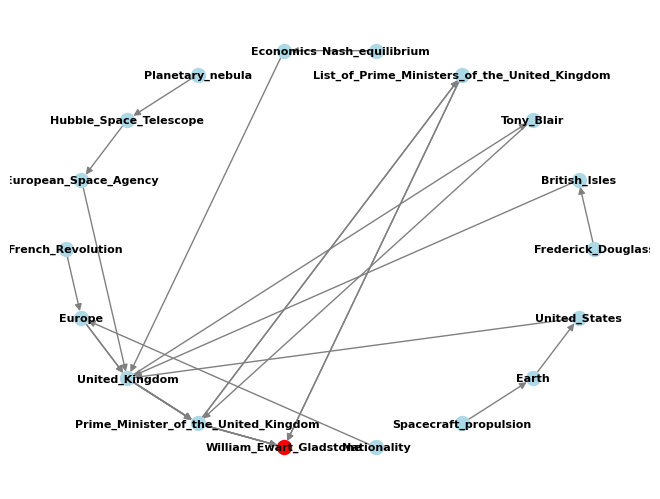

In [8]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


# Create a directed graph
G = nx.MultiDiGraph()


#j =110
j = 110
for people in target_people_list.iloc[j:j+1]:
    target_article = people

    #Find all the path that this target have
    for i, path in path_target_people[path_target_people.target == people].iterrows():
        # Need to add the path of each nodes
        path_target = path.path
        # Handle return case
        for j in range(len(path_target)):
            #Iterate to each words of the (partial) list
            partial_path = path_target[j]
            for k in range(len(partial_path)-1):
                # Add edges to the graph
                G.add_edge(partial_path[k], partial_path[k+1])

# Draw the graph
    #Node size:
    nd = 100
    pos = nx.shell_layout(G)
    nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=nd, node_color='lightblue', font_color='black', font_size=8, edge_color='gray')

# Highlight the target article
    nx.draw_networkx_nodes(G, pos, nodelist=[target_article], node_color='red', node_size=nd)

    plt.show()


return
return
return
return


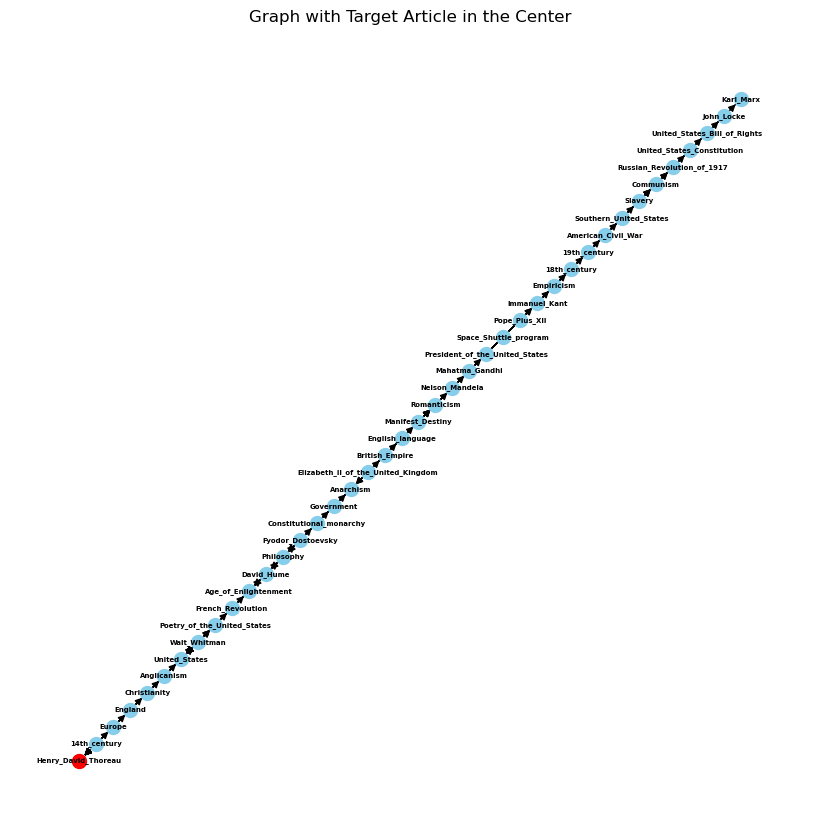

In [9]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

fs = (8, 8)
# Create a directed graph
G = nx.MultiDiGraph()
j = 2

for people in target_people_list.iloc[j:j+1]:
    target_article = people
    #Find all the path that this target have
    for i, path in path_target_people[path_target_people.target == people].iterrows():
        # Need to add the path of each nodes
        path_target = path.path
        # Handle return case
        for j in range(len(path_target)):
            if j > 1:
                print('return')
            #Iterate to each words of the (partial) list
            partial_path = path_target[j]
            for k in range(len(partial_path)-1):
                # Add edges to the graph
                G.add_edge(partial_path[k], partial_path[k+1])

    # Set the custom layout with the target article in the center
    layout = {target_article: tuple(element/2 for element in fs)}
    a = tuple((element+1)/2 for element in fs)
    for node in G.nodes:
        if node != target_article:
            layout[node] = a  # You can adjust these coordinates based on your preference
            a = tuple(element+(1/2) for element in a)
plt.figure(figsize=fs)
# Draw the graph
nx.draw(G, layout, with_labels=True, node_size=100, node_color='skyblue', font_size=5, font_color='black', font_weight='bold', arrowsize=10)

# Highlight the target article
nx.draw_networkx_nodes(G, layout, nodelist=[target_article], node_color='red', node_size=100)

plt.title("Graph with Target Article in the Center")
plt.show()


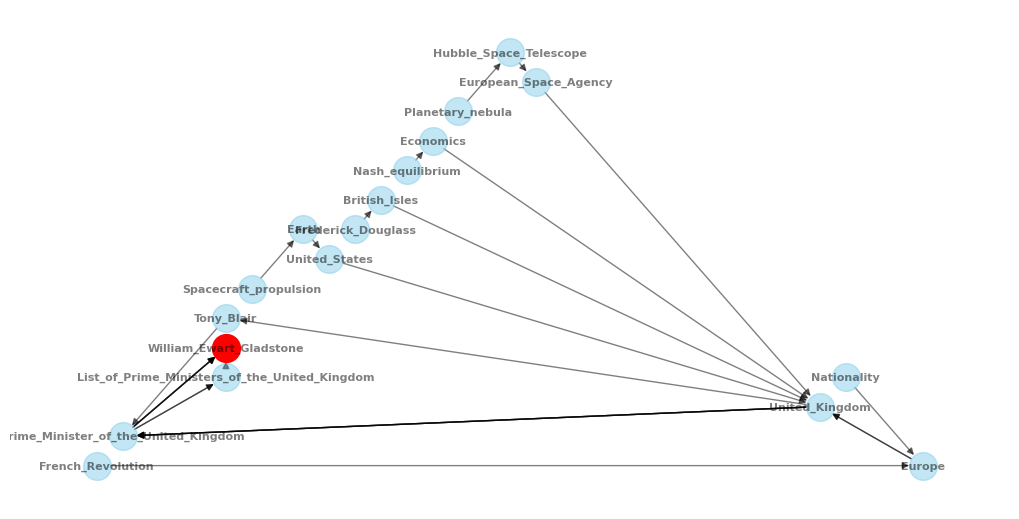

In [10]:
graph = nx.MultiDiGraph()


j = 110
for people in target_people_list.iloc[j:j+1]:
    target_article = people
    #Find all the path that this target have
    for i, path in path_target_people[path_target_people.target == people].iterrows():
        # Need to add the path of each nodes
        path_target = path.path
        # Handle return case
        for j in range(len(path_target)):
            if j > 1:
                print('return')
            #Iterate to each words of the (partial) list
            partial_path = path_target[j]
            for k in range(len(partial_path)-1):
                # Add edges to the graph
                graph.add_edge(partial_path[k], partial_path[k+1])


 
#nx.draw_networkx_nodes(graph, pos, node_size=10)  #, node_color=node_colors)
#nx.draw_networkx_edges(graph, pos, alpha=0.5)
    plt.figure(figsize=(10, 5))
    pos = nx.planar_layout(graph) 
    nx.draw(graph, pos, with_labels=True, node_size=400, node_color='skyblue', font_size=8, font_color='black', font_weight='bold', arrowsize=10, alpha = 0.5)
    nx.draw_networkx_nodes(graph, pos, nodelist=[target_article], node_color='red', node_size=400)


plt.show()


Francis_Bacon


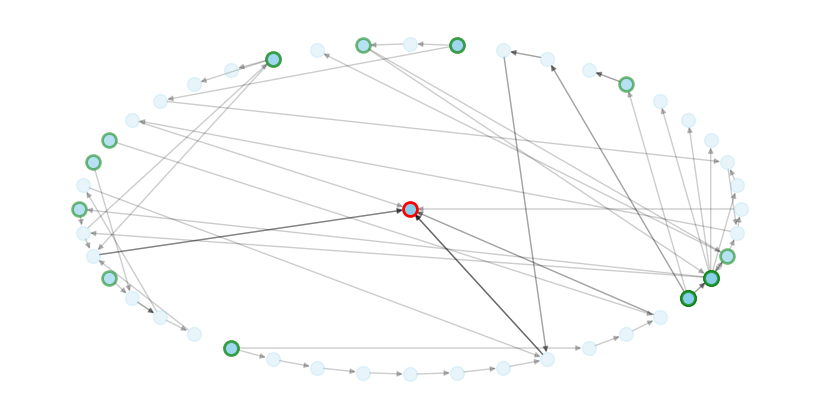

Voltaire


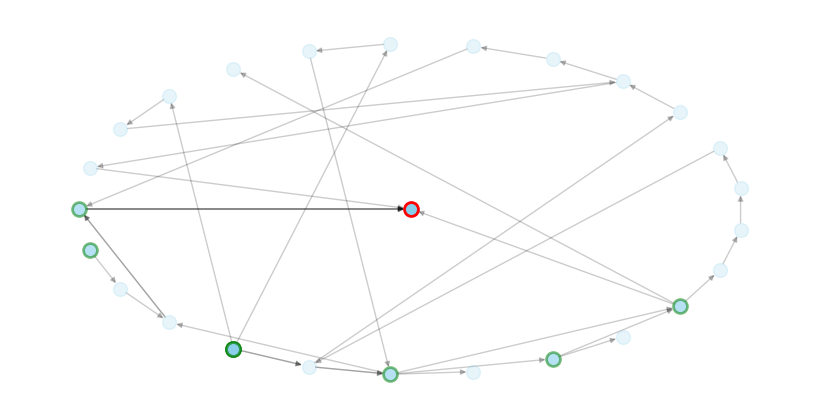

Mao_Zedong


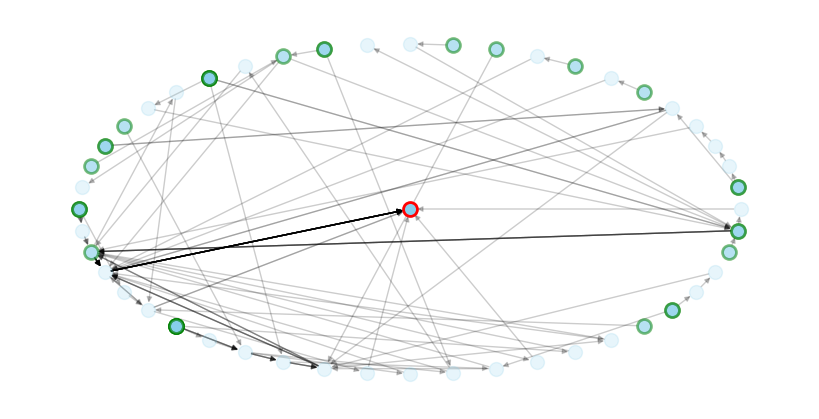

Jesus


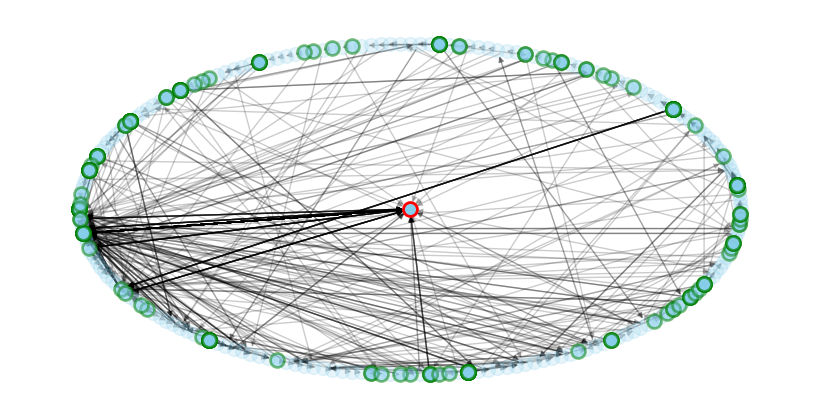

Napoleon_I_of_France


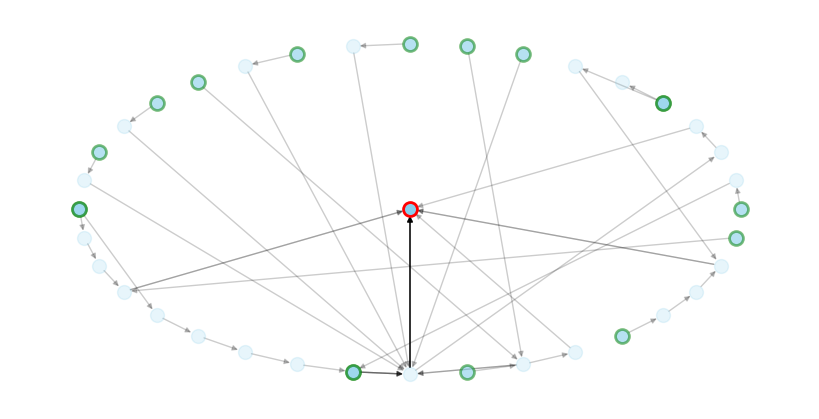

Adolf_Hitler


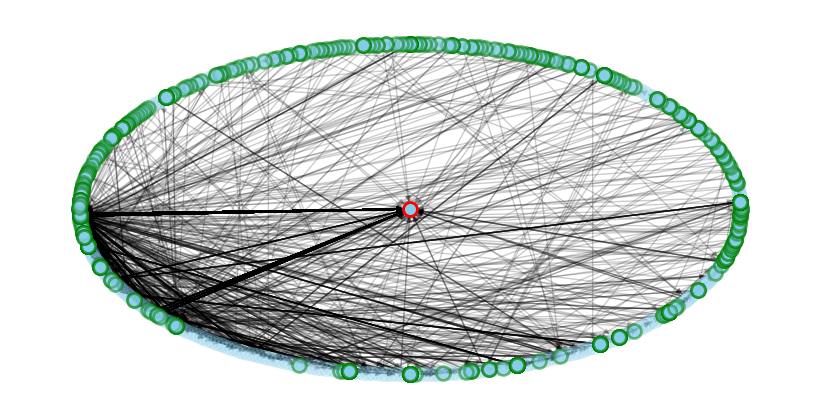

Tony_Blair


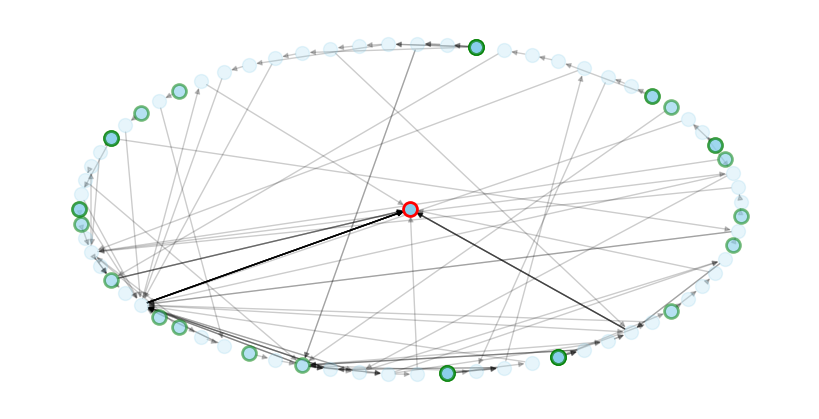

Euclid


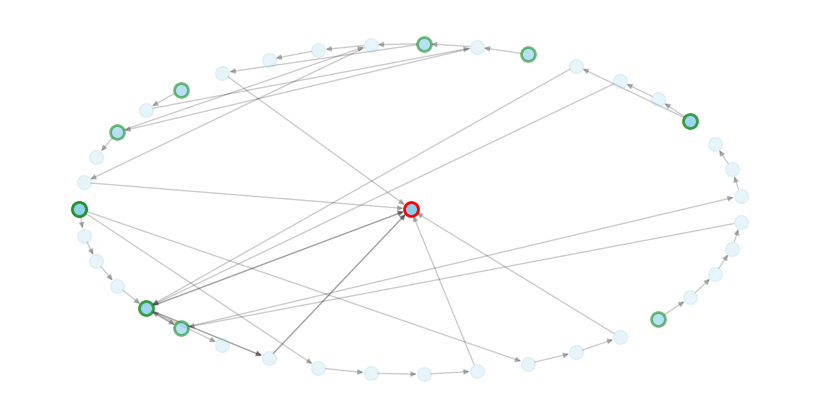

Heraclius


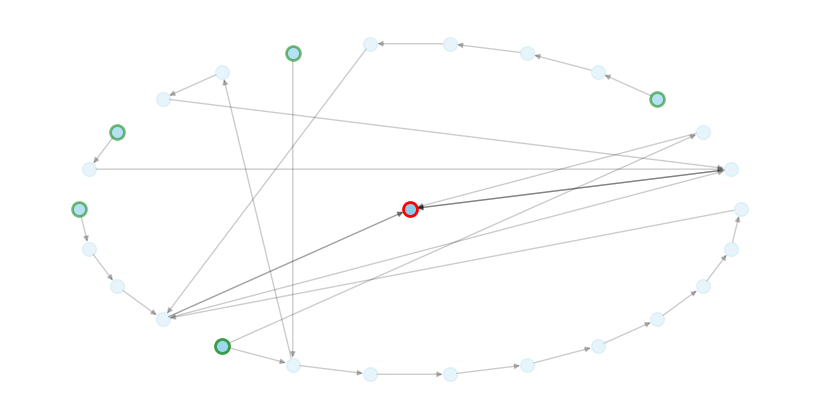

Brothers_Grimm


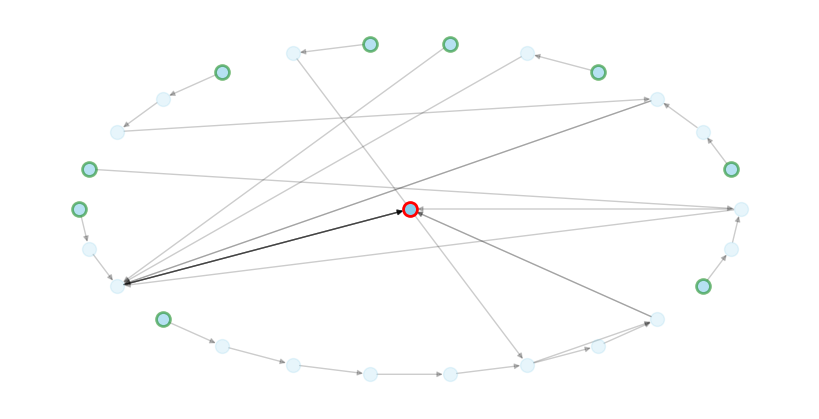

In [17]:
j = 0
source_list = []

for people in target_people_list.iloc[10:20]:
    graph = nx.MultiDiGraph()
    target_article = people
    print(target_article)
    source_list = []

    #Find all the path that this target have
    for i, path in path_target_people[path_target_people.target == people].iterrows():
        # Need to add the path of each nodes
        path_target = path.path
        # Handle return case
        for j in range(len(path_target)):
 
            #Iterate to each words of the (partial) list
            partial_path = path_target[j]
            for k in range(len(partial_path)-1):
                target = partial_path[k+1]
                if target != target_article:
                    #target = str(i) + '.' + target
                    target = target
                # Add edges to the graph
                #cur_nod = str(i) + '.' + path_target.path[j]
                cur_nod = partial_path[k]
                if k == 0: 
                    source_list.append(cur_nod)
                graph.add_edge(cur_nod, target)
                graph.add_node(cur_nod)


    plt.figure(figsize=(8, 4))

    pos = nx.shell_layout(G = graph.subgraph(set(graph) - {target_article}))
    pos[target_article] = np.array([0, 0])


    #node size
    nd = 100
    color_noded = 'skyblue'
    color_edge_target = 'red'
    color_edge_source = 'green'
    #nx.flow_hierarchy(graph)
    nx.draw(graph, pos, with_labels=False, node_size=nd, node_color= color_noded, font_size=5, font_color='black', font_weight='bold', arrowsize=8, alpha = 0.2)
    nx.draw_networkx_nodes(graph, pos, nodelist=[target_article], node_color= color_noded, edgecolors = color_edge_target, node_size=nd, linewidths=2)
    nx.draw_networkx_nodes(graph, pos, nodelist=source_list, node_color= color_noded, edgecolors=color_edge_source, node_size=nd, linewidths=2, alpha = 0.5)
 

    plt.show()


# Repartition of last linkage

Dans mes plots on prends pas en compte le count des paths dans l'épaisseur des edge, ça pourrait être qch à étudier

In [13]:

# Add the name of the last article before reaching the target in the path 
path_target_people['last_before_target'] = 'None'
for i, row in path_target_people.iterrows():
    if len(row.path[-1]) <2:
        print(row.path[-1])
        print(i)
    path_target_people.loc[i, 'last_before_target'] = row.path[-1][-2]
path_target_people

# Count duplicates of the target, last_before_target pairs 
last_link = path_target_people.loc[:,['target', 'last_before_target']]
last_link['count_duplicates'] = last_link.groupby(['target', 'last_before_target'])['last_before_target'].transform('count')
last_link.drop_duplicates(subset=['target', 'last_before_target'], inplace=True)

# Add the percentage that the name of the last article before reaching the target represent
last_link['repartition_perc'] = 1000.0
for people in last_link.target.unique():
    l = last_link[last_link.target == people].count_duplicates
    last_link.loc[last_link.target == people, 'repartition_perc'] = last_link.loc[last_link.target == people, 'count_duplicates']/last_link[last_link.target == people].count_duplicates.sum()*100

# Add the general count of value according to the category of the last article before reaching the target
last_link['category_last'] = [ ('people' if last in list_people.values else 'non_people') for last in last_link.last_before_target ]
target_cat_last = last_link.groupby(['target', 'category_last'])['count_duplicates'].sum().reset_index()
target_cat_last.rename(columns={'count_duplicates': 'count_by_categories'}, inplace = True)
last_link = last_link.merge(target_cat_last, on = ['target', 'category_last'], how = 'left')

display(last_link)

,target,last_before_target,count_duplicates,repartition_perc,category_last,count_by_categories
0,John_F._Kennedy,President_of_the_United_States,12,54.545455,non_people,21
1,Elizabeth_I_of_England,Francis_Drake,1,5.000000,people,8
2,Elizabeth_I_of_England,James_I_of_England,1,5.000000,people,8
3,Elizabeth_I_of_England,Henry_VIII_of_England,5,25.000000,people,8
4,Elizabeth_I_of_England,Windsor_Castle,1,5.000000,non_people,12
...,...,...,...,...,...,...
1459,Felix_Mendelssohn,Romanticism,1,25.000000,non_people,4
1460,Zoroaster,Persian_Empire,1,25.000000,non_people,4
1461,Christopher_Columbus,15th_century,1,6.666667,non_people,15
1462,Robert_Oppenheimer,Richard_Feynman,1,20.000000,people,2


In [14]:
last_link[last_link.target == 'Robert_Oppenheimer']

,target,last_before_target,count_duplicates,repartition_perc,category_last,count_by_categories
825,Robert_Oppenheimer,History_of_nuclear_weapons,3,60.0,non_people,3
1214,Robert_Oppenheimer,Linus_Pauling,1,20.0,people,2
1462,Robert_Oppenheimer,Richard_Feynman,1,20.0,people,2


In [15]:
last_people = last_link.loc[last_link.category_last == 'people',]
last_not_people = last_link.loc[last_link.category_last == 'non_people',]

In [16]:
print(last_not_people.count_duplicates.sum(), last_people.count_duplicates.sum())
print(len(last_not_people.count_duplicates), len(last_people.count_duplicates))

5129 781
1128 336


# Autre

In [5]:
result_dict, all_articles = create_dictionary_from_tsv("dataset/wikispeedia_paths-and-graph/categories.tsv")

In [ ]:
result_dict

In [10]:
print(len(all_articles), len(result_dict))

5204 4598


In [74]:
target_cat_last

,target,category_last,count_by_categories
0,Abel_Tasman,non_people,3
1,Abel_Tasman,people,3
2,Abraham_Lincoln,non_people,35
3,Adam_Smith,non_people,8
4,Adam_Smith,people,1
...,...,...,...
639,Zachary_Taylor,people,1
640,Zheng_He,non_people,5
641,Ziad_Jarrah,non_people,5
642,Zionism,non_people,10


583.0 0.0
46.0 0.0


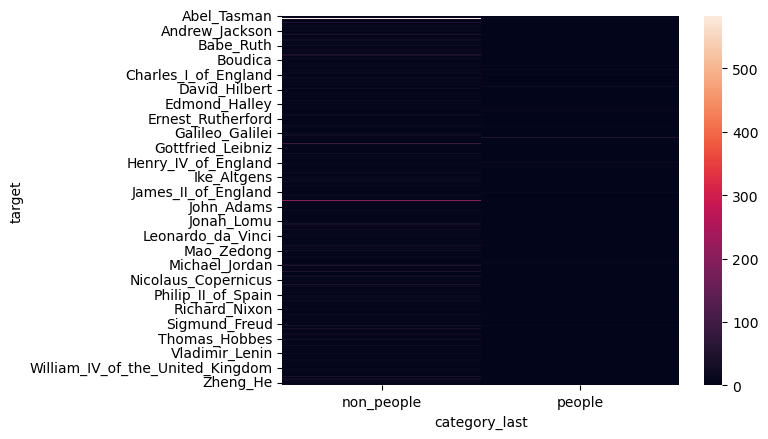

/Users/juliekorber/opt/anaconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/juliekorber/opt/anaconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/juliekorber/opt/anaconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/juliekorber/opt/anaconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse i

<Axes: xlabel='category_last', ylabel='target'>

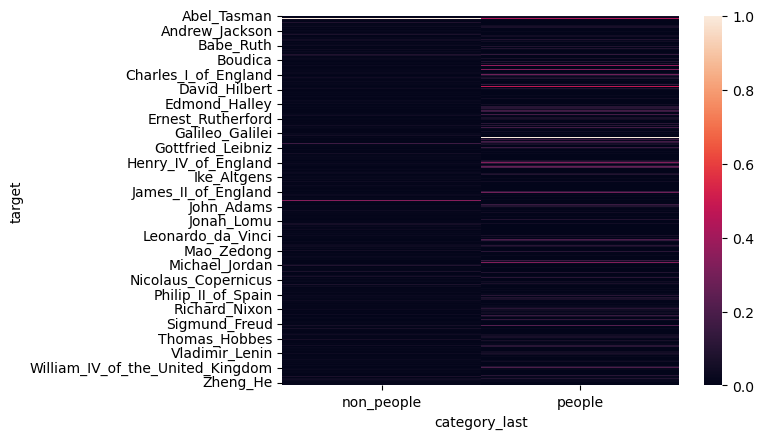

In [18]:
a = target_cat_last.pivot(index="target", columns="category_last", values="count_by_categories")
a.fillna(0, inplace = True)
print(max(a.non_people), min(a.non_people))
print(max(a.people), min(a.people))
import seaborn as sns
sns.heatmap(a, annot=False)
plt.show()
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
a[['non_people', 'people']] = scaler.fit_transform(a)
sns.heatmap(a, annot=False)

<Axes: xlabel='category_last', ylabel='target'>

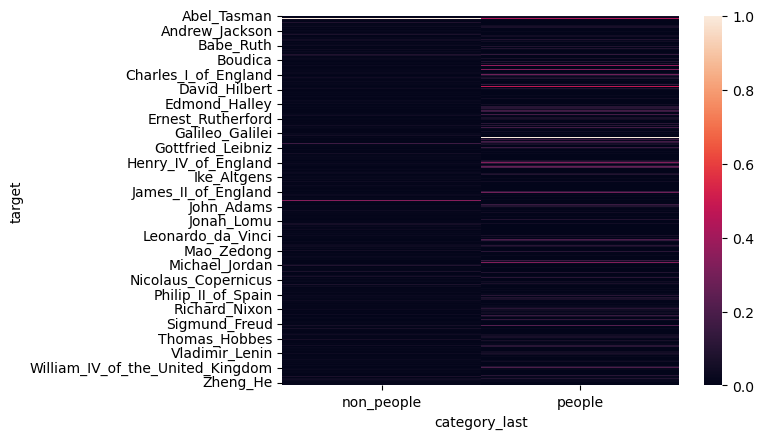

In [83]:
import seaborn as sns
sns.heatmap(a, annot=False)
